Number of unique users: 943
Number of unique items: 1662
Max user_id: 942
Max item_id: 1661
--> Epoch 0
ave mse 1.267 ===> Total training time : 0.432 seconds
--> Epoch 1
ave mse 0.926 ===> Total training time : 2.853 seconds
--> Epoch 2
ave mse 0.884 ===> Total training time : 5.437 seconds
--> Epoch 3
ave mse 0.866 ===> Total training time : 8.421 seconds
--> Epoch 4
ave mse 0.857 ===> Total training time : 10.977 seconds
--> Epoch 5
ave mse 0.85 ===> Total training time : 13.458 seconds
--> Epoch 6
ave mse 0.844 ===> Total training time : 15.889 seconds
--> Epoch 7
ave mse 0.84 ===> Total training time : 19.311 seconds
--> Epoch 8
ave mse 0.834 ===> Total training time : 21.909 seconds
--> Epoch 9
ave mse 0.826 ===> Total training time : 24.996 seconds
--> Epoch 10
ave mse 0.814 ===> Total training time : 27.622 seconds
--> Epoch 11
ave mse 0.797 ===> Total training time : 30.023 seconds
--> Epoch 12
ave mse 0.774 ===> Total training time : 33.103 seconds
--> Epoch 13
ave mse 0.747 

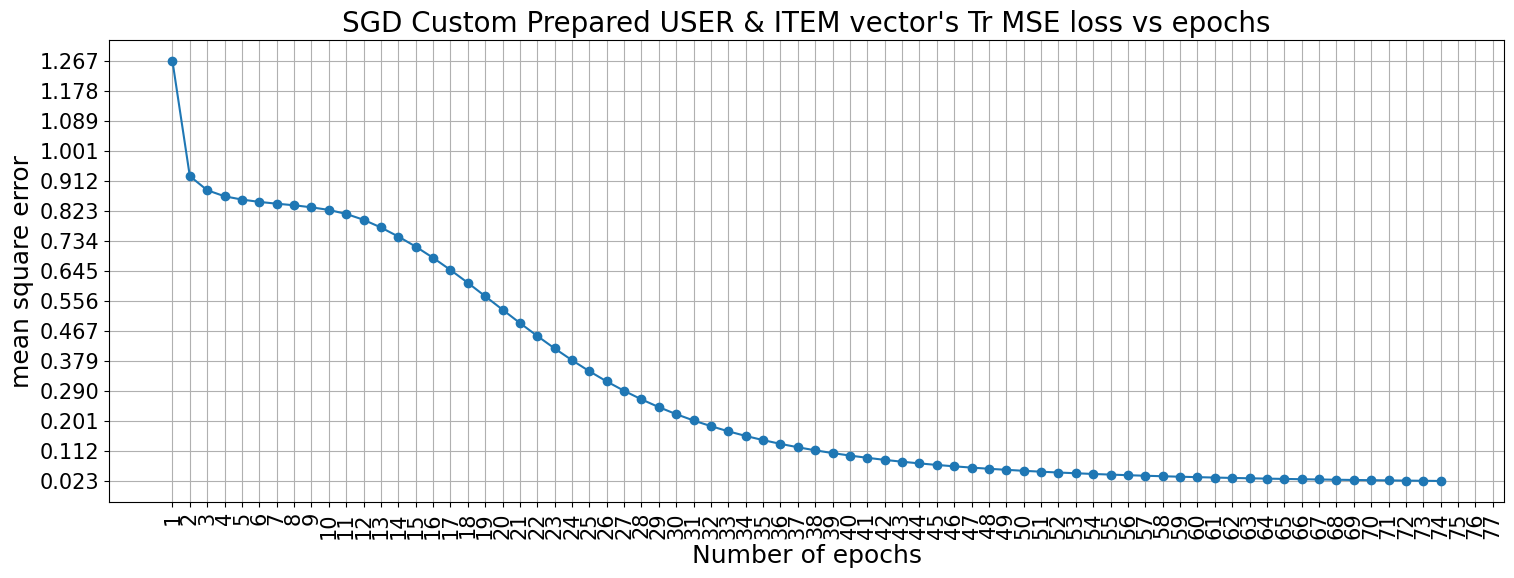

In [10]:
import time
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


data = pd.read_csv('ratings_train.csv')

# This matrix is represented by R, where each row represents a user and each column represents an item - entries are ratings
# We will factorize this to two lower rank matrices P and Q; so their product approximates R.
# Each row of P : User preference ( as a vector )
# Each row of Q : Item characteristic ( as a vector )

# Ensure user_id and item_id are zero-based

data['user_id'] = pd.Categorical(data['user_id']).codes
data['item_id'] = pd.Categorical(data['item_id']).codes

# Debug: Check the max values after reindexing
print(f"Number of unique users: {len(data.user_id.unique())}")
print(f"Number of unique items: {len(data.item_id.unique())}")
print(f"Max user_id: {data.user_id.max()}")
print(f"Max item_id: {data.item_id.max()}")

# Create the sparse matrix with the correct shape
ratings = csr_matrix(
    (data.rating.values, (data.user_id.values, data.item_id.values)),
    shape=(len(data.user_id.unique()), len(data.item_id.unique()))  # Shape should be (943, 1662)
).toarray()

# The (i,j) entry of R can be approx. by P[i,:] * Q[:,j] - goal is to minimize the error 


class MatrixFactorization():

    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # constant that multiplies the update term
        self.alpha = alpha  # lambda constant for regularization
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    # np.random.normal
    # It initializes the matrices with normally distributed random values.
    # The standard deviation (scale) is set to 1/self.n_factors, ensuring small initial values to prevent divergence in gradient descent.

    def initialize(self):
        self.now = time.time()

        # initialize the bias values - represents deviation of ratings to avg ratings
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)

        # initialize user & item vectors - latent vectors
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))

        # compute global bias 
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    # u, i : index - equation in the jupyter notebook
    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])

        # update user and item vector 
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0  # to store the sum of squared errors between predicted and actual ratings.

        # iterate thru lst which contains indices of known ratings
        for index in self.ind_lst:

            # extract user item info indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"--> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time : {temp} seconds")

    # The early_stopping function is used to stop training early if the model's performance stops improving
    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time())
                if self.verbose:
                    print(f"Convergence after {epoch} epochs time took : {temp} seconds")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    # self.mse_lst[-2] and self.mse_lst[-1] are the MSE values of the previous and current epochs, respectively.
    # This checks if the change in MSE between the last two epochs is smaller than or equal to a predefined tolerance (self.tol).
    # self.tol is a small threshold value that indicates whether the model’s performance improvement is insignificant.

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.plot_the_score()

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("SGD Custom Prepared USER & ITEM vector's Tr MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num + 5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst), 15), fontsize=15)
        plt.grid()
        plt.show()


obj = MatrixFactorization(ratings)
obj.fit()
